# EE4211 Data Science for IoT: Project

## Team Number: 23

Team Members:
1. Tan Kai Xin, Nicole (A0237969E)
2. Erik Naeslund (A0307005W)
3. Peng Ziwei (A0279207X)

## Question 2: Forecasting (10 Marks)

### Import Statements

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import requests
import json
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPRegressor
import matplotlib.dates as mdates

### Data Extraction

In [ ]:
def generate_timestamps(start_date, end_date, interval):
    return [start_date + timedelta(minutes=interval * i) 
            for i in range(int((end_date - start_date).total_seconds() // (interval * 60)) + 1)]

In [ ]:
def fetch_data_for_time(year, month, day, hour, minute, second):
    year = str(year)
    month = str(month).zfill(2)
    day = str(day).zfill(2)
    hour = str(hour).zfill(2)
    minute = str(minute).zfill(2)
    second = str(second).zfill(2)

    site = f'https://api.data.gov.sg/v1/transport/carpark-availability?date_time={year}-{month}-{day}T{hour}%3A{minute}%3A{second}'
    response_API = requests.get(site)
    
    if response_API.status_code == 200:
        data = json.loads(response_API.text)
        if "items" in data and len(data["items"]) > 0:
            print(f"Data available for {year}-{month}-{day} {hour}:{minute}:{second}")
            return data["items"][0]["carpark_data"]
        else:
            print(f"No data available for {year}-{month}-{day} {hour}:{minute}:{second}")
            return None
    else:
        print(f"Failed to fetch data. Status code: {response_API.status_code}")
        return None

In [ ]:
def compute_availability_ratio(carpark_data):
    total_availability = 0
    valid_carpark_count = 0
    
    for carpark in carpark_data:
        carpark_info = carpark.get("carpark_info", [{}])[0]
        total_lots = carpark_info.get("total_lots", None)
        lots_available = carpark_info.get("lots_available", None)
        
        try:
            total_lots = int(total_lots)
            lots_available = int(lots_available)
        except (TypeError, ValueError):
            total_lots, lots_available = None, None
        
        if total_lots and lots_available is not None and total_lots > 0:
            availability_ratio = lots_available / total_lots
            total_availability += availability_ratio
            valid_carpark_count += 1
    
    return total_availability / valid_carpark_count if valid_carpark_count > 0 else None

In [ ]:
def process_data(start_date, end_date, interval, data_fetcher):
    timestamps = generate_timestamps(start_date, end_date, interval)
    data_collected = []
    
    for timestamp in timestamps:
        carpark_data = data_fetcher(timestamp.year, timestamp.month, timestamp.day, 
                                    timestamp.hour, timestamp.minute, timestamp.second)
        
        if carpark_data:
            avg_availability = compute_availability_ratio(carpark_data)
            if avg_availability is not None:
                data_collected.append((timestamp, avg_availability))
    
    df = pd.DataFrame(data_collected, columns=['Timestamp', 'Average Availability']).drop_duplicates(subset='Timestamp')
    
    df.set_index('Timestamp', inplace=True)
    
    df['Average Availability'] = df['Average Availability'].interpolate(method='cubic')
    
    return df

In [ ]:
start_july = datetime(2024, 7, 1, 0, 0, 0)
end_july = datetime(2024, 7, 31, 23, 59, 59)
start_august = datetime(2024, 8, 1, 0, 0, 0)
end_august = datetime(2024, 8, 31, 23, 59, 59)
interval = 20

def resample_to_hourly_average(df):
    hourly_df = df.resample('1H').mean()
    return hourly_df

july_data_df = process_data(start_july, end_july, interval, fetch_data_for_time)
july_data_hourly_df = resample_to_hourly_average(july_data_df)
july_data_hourly_df.to_csv('july_2024_carpark_availability_hourly.csv', index=True)

august_data_df = process_data(start_august, end_august, interval, fetch_data_for_time)
august_data_hourly_df = resample_to_hourly_average(august_data_df)
august_data_hourly_df.to_csv('august_2024_carpark_availability_hourly.csv', index=True)

In [ ]:
def load_interpolate_save(input_file, output_file):
    df = pd.read_csv(input_file, parse_dates=['Timestamp'], index_col='Timestamp')
    
    df['Average Availability'] = df['Average Availability'].interpolate(method='cubic')
    
    df.to_csv(output_file, index=True)
    
    return df

july_data_df = load_interpolate_save('july_2024_carpark_availability_hourly.csv', 'july_2024_carpark_availability_interpolated.csv')
august_data_df = load_interpolate_save('august_2024_carpark_availability_hourly.csv', 'august_2024_carpark_availability_interpolated.csv')
july_data_df = july_data_df.reset_index()
august_data_df = august_data_df.reset_index()

print("After resetting index:")
print("July DataFrame head:\n", july_data_df.head())
print("August DataFrame head:\n", august_data_df.head())

### Question 2.1

In this part, you will build a model to forecast the hourly carpark availability in the furture (averaged across all carparks instead of looking at each carpark individually). Can you explain why you may want to forecast the carpark availability in the future? Who would find this information valuable? What can you do if you have a good forecasting model?

- Purpose of Forecasting Carpark Availability: Forecasting carpark availability helps drivers find parking spaces more easily, reducing the time spent searching and alleviating traffic congestion. Real-time insights allow drivers to make informed decisions, preventing overcrowding in certain areas. Additionally, forecasting carpark usage may encourage some drivers to choose other transportation modes, such as metro or bus services, if parking is limited.
- Value of Information: This information is valuable not only to drivers but also to city planners and transportation authorities. By understanding patterns in carpark occupancy, planners can make better decisions about parking fees, infrastructure investments, and adjustments to public transit routes and schedules, helping to balance demand across different transportation modes.
- Environmental Benefits: A reliable forecasting model could also support environmental goals. By reducing the time drivers spend searching for parking, fuel consumption and emissions are minimized, contributing to cleaner air and a more sustainable urban environment.
- Applications of a Good Forecasting Model: With a good forecasting model, we could not only predict average carpark availability but also provide detailed forecasts for each carpark individually. This would support dynamic pricing, better resource allocation, and planning for future transportation needs, enhancing the efficiency of both private vehicle use and public transit systems.

### Question 2.2
Build a *ridge regression* model to forecast the hourly carpark availability for a given month. Use the month of July 2024 as a training dataset and the month of August 2024 as the test dataset. For this part, do not use additional datasets. The target is the hourly carpark availability and you will have to decide what features you want to use. Generate two plots (i) Time Series plot of the actual and predicted hourly values (ii) Scatter plot of actual vs predicted hourly values (along with a line showing how good the fit is).

In [29]:
july_data_df = pd.read_csv('july_2024_carpark_availability_interpolated.csv')
july_data_df = july_data_df.reset_index()
august_data_df = pd.read_csv('august_2024_carpark_availability_interpolated.csv')
august_data_df = august_data_df.reset_index()

In [30]:
def add_dummy_variables(df):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], dayfirst=True)
    df['Weekday'] = df['Timestamp'].dt.dayofweek
    df = pd.get_dummies(df, columns=['Weekday'], prefix='Day', drop_first=False)
    df['Hour'] = df['Timestamp'].dt.hour
    df = pd.get_dummies(df, columns=['Hour'], prefix='Hour', drop_first=False)
    return df

In [31]:
def add_cyclic_variables(df):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], dayfirst=True)
    df['Weekday'] = df['Timestamp'].dt.dayofweek
    df['Hour'] = df['Timestamp'].dt.hour
    df['Weekday_sin'] = np.sin(2 * np.pi * df['Weekday'] / 7)
    df['Weekday_cos'] = np.cos(2 * np.pi * df['Weekday'] / 7)
    df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df.drop(columns=['Weekday', 'Hour'], inplace=True)
    return df

In [32]:
def runner_function_with_cv_scores(july_data_df, august_data_df, alphas):
    july_data_dummy = add_dummy_variables(july_data_df.copy())
    august_data_dummy = add_dummy_variables(august_data_df.copy())
    july_data_cyclic = add_cyclic_variables(july_data_df.copy())
    august_data_cyclic = add_cyclic_variables(august_data_df.copy())
    
    X_july_dummy = july_data_dummy.drop(columns=['Average Availability', 'Timestamp'])
    y_july_dummy = july_data_dummy['Average Availability']
    X_august_dummy = august_data_dummy.drop(columns=['Average Availability', 'Timestamp'])
    y_august_dummy = august_data_dummy['Average Availability']
    
    X_july_cyclic = july_data_cyclic.drop(columns=['Average Availability', 'Timestamp'])
    y_july_cyclic = july_data_cyclic['Average Availability']
    X_august_cyclic = august_data_cyclic.drop(columns=['Average Availability', 'Timestamp'])
    y_august_cyclic = august_data_cyclic['Average Availability']
    
    cv_scores_dummy = []
    cv_scores_cyclic = []
    
    for alpha in alphas:
        ridge_dummy = Ridge(alpha=alpha)
        scores_dummy = cross_val_score(ridge_dummy, X_july_dummy, y_july_dummy, cv=10, scoring='neg_mean_squared_error')
        cv_scores_dummy.append(-np.mean(scores_dummy))

        ridge_cyclic = Ridge(alpha=alpha)
        scores_cyclic = cross_val_score(ridge_cyclic, X_july_cyclic, y_july_cyclic, cv=10, scoring='neg_mean_squared_error')
        cv_scores_cyclic.append(-np.mean(scores_cyclic))

    best_alpha_dummy = alphas[np.argmin(cv_scores_dummy)]
    best_alpha_cyclic = alphas[np.argmin(cv_scores_cyclic)]
    
    ridge_best_dummy = Ridge(alpha=best_alpha_dummy)
    ridge_best_dummy.fit(X_july_dummy, y_july_dummy)
    y_pred_august_dummy = ridge_best_dummy.predict(X_august_dummy)
    test_error_dummy = mean_squared_error(y_august_dummy, y_pred_august_dummy)
    
    ridge_best_cyclic = Ridge(alpha=best_alpha_cyclic)
    ridge_best_cyclic.fit(X_july_cyclic, y_july_cyclic)
    y_pred_august_cyclic = ridge_best_cyclic.predict(X_august_cyclic)
    test_error_cyclic = mean_squared_error(y_august_cyclic, y_pred_august_cyclic)
    
    results = {
        "dummy": {
            "alphas": alphas,
            "cv_scores": cv_scores_dummy,
            "best_alpha": best_alpha_dummy,
            "test_error": test_error_dummy,
            "y_true": y_august_dummy,
            "y_pred": y_pred_august_dummy,
            "timestamps": august_data_dummy['Timestamp']
        },
        "cyclic": {
            "alphas": alphas,
            "cv_scores": cv_scores_cyclic,
            "best_alpha": best_alpha_cyclic,
            "test_error": test_error_cyclic,
            "y_true": y_august_cyclic,
            "y_pred": y_pred_august_cyclic,
            "timestamps": august_data_cyclic['Timestamp']
        }
    }
    return results

alphas = np.logspace(-6, 6, 13)

results = runner_function_with_cv_scores(july_data_df, august_data_df, alphas)

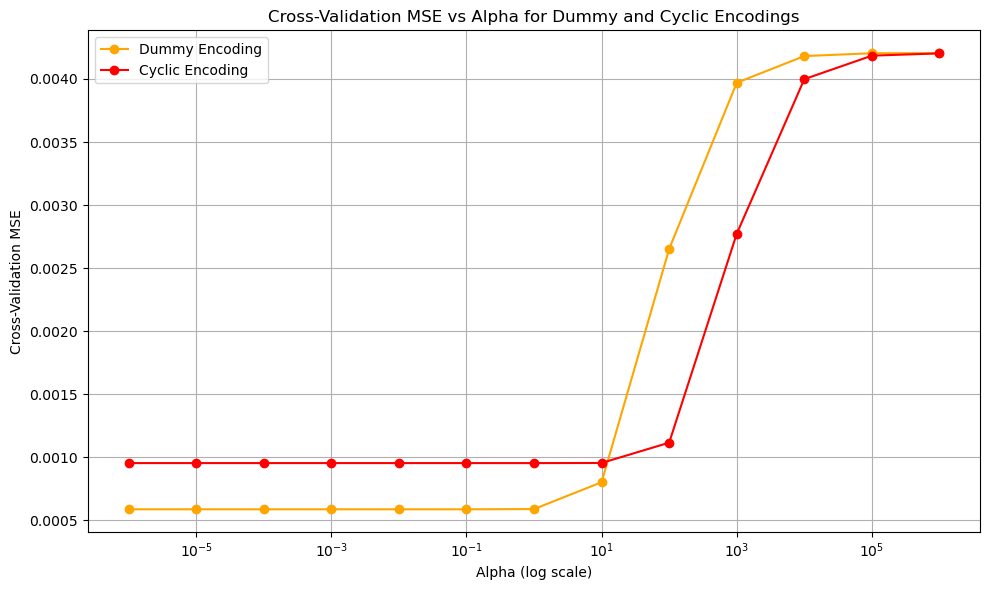

In [33]:
def plot_cv_score_vs_alpha(results):
    """
    Plots cross-validation MSE vs. alpha for both dummy and cyclic encoding results.
    
    Parameters:
    results (dict): Dictionary containing cross-validation scores for each alpha, returned by runner_function_with_cv_scores.
    """
    plt.figure(figsize=(10, 6))

    plt.plot(results['dummy']['alphas'], results['dummy']['cv_scores'], label='Dummy Encoding', marker='o', color='orange')
    
    plt.plot(results['cyclic']['alphas'], results['cyclic']['cv_scores'], label='Cyclic Encoding', marker='o', color='red')
    
    plt.xscale('log')
    plt.xlabel('Alpha (log scale)')
    plt.ylabel('Cross-Validation MSE')
    plt.title('Cross-Validation MSE vs Alpha for Dummy and Cyclic Encodings')
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()

plot_cv_score_vs_alpha(results)

#### (i) Time Series Plot

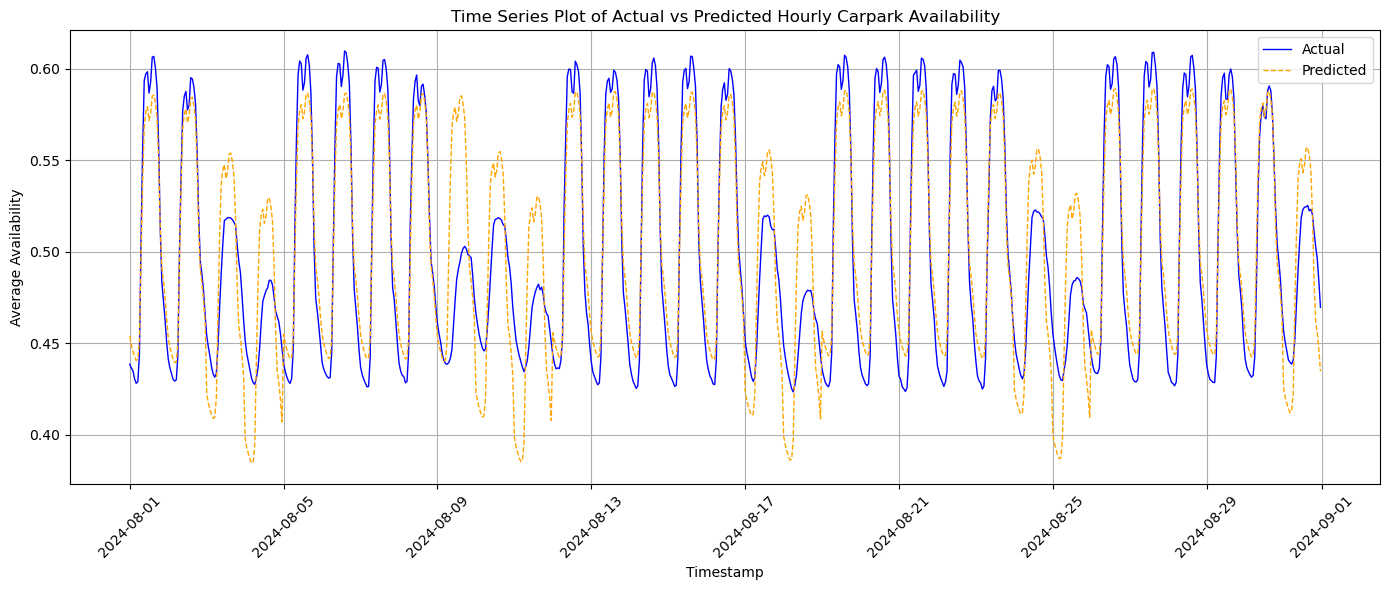

In [34]:
def plot_time_series(results):
    """
    Plots a time series of actual vs. predicted hourly carpark availability for both dummy and cyclic encodings.
    
    Parameters:
    results (dict): Dictionary containing model results for dummy and cyclic encodings, returned by runner_function.
    """
    plt.figure(figsize=(14, 6))

    plt.plot(results['dummy']['timestamps'], results['dummy']['y_true'], label='Actual', color='blue', linewidth=1)
    plt.plot(results['dummy']['timestamps'], results['dummy']['y_pred'], label='Predicted', color='orange', linestyle='dashed', linewidth=1)
    """
    # Plot actual vs. predicted for cyclic encoding
    plt.plot(results['cyclic']['timestamps'], results['cyclic']['y_true'], label='Actual (Cyclic)', color='green', linewidth=1)
    plt.plot(results['cyclic']['timestamps'], results['cyclic']['y_pred'], label='Predicted (Cyclic)', color='red', linestyle='dashed', linewidth=1)
    """
    plt.xlabel('Timestamp')
    plt.ylabel('Average Availability')
    plt.title('Time Series Plot of Actual vs Predicted Hourly Carpark Availability')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

plot_time_series(results)

#### (ii) Scatter Plot

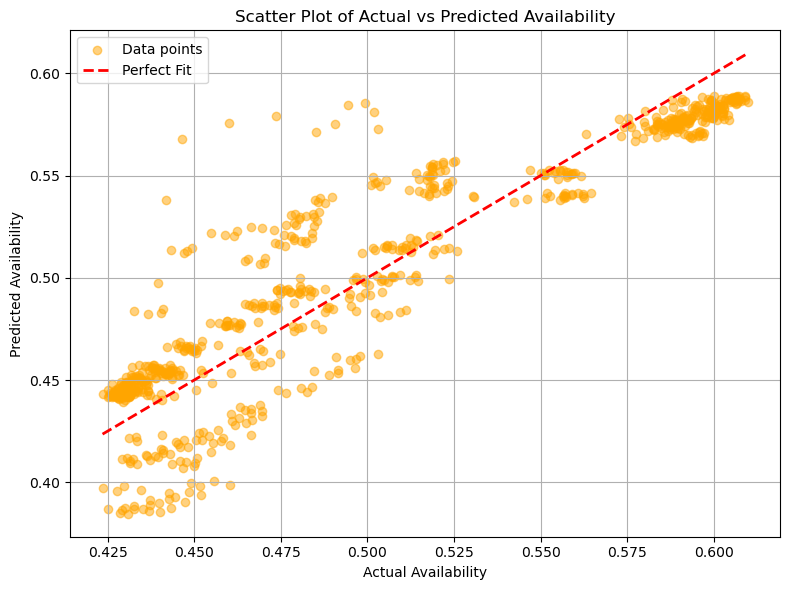

In [35]:
def plot_scatter(results):

    plt.figure(figsize=(8, 6))

    plt.scatter(results['dummy']['y_true'], results['dummy']['y_pred'], alpha=0.5, color='orange', label='Data points')

    # plt.scatter(results['cyclic']['y_true'], results['cyclic']['y_pred'], alpha=0.5, color='red', label='Cyclic Encoding')

    y_min = min(results['dummy']['y_true'].min(), results['cyclic']['y_true'].min())
    y_max = max(results['dummy']['y_true'].max(), results['cyclic']['y_true'].max())
    plt.plot([y_min, y_max], [y_min, y_max], 'r--', lw=2, label='Perfect Fit')

    plt.xlabel('Actual Availability')
    plt.ylabel('Predicted Availability')
    plt.title('Scatter Plot of Actual vs Predicted Availability')
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()

plot_scatter(results)

In [37]:
y_true = results['dummy']['y_true']
y_pred = results['dummy']['y_pred']
mse_ridge = np.mean((y_true - y_pred) ** 2)
print("Mean Squared Error for Ridge Regression:", mse_ridge)

Mean Squared Error for Ridge Regression: 0.000684455535495323


### Question 2.3
Build a *random forest (RF) regressor* model to forecast the hourly carpark availability for a given month. Use the month of July 2024 as a training dataset and the month of August 2024 as the test dataset. For this part, do not use additional datasets. The target is the hourly carpark availability and you will have to decide what features you want to use. Generate two plots (i) Time Series plot of the actual and predicted hourly values (ii) Scatter plot of actual vs predicted hourly values (along with a line showing how good the fit is).

In [38]:
august_data_path = 'august_2024_carpark_availability_interpolated.csv'
july_data_path = 'july_2024_carpark_availability_interpolated.csv'
august_df = pd.read_csv(august_data_path)
july_df = pd.read_csv(july_data_path)

def data_processing(df):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d/%m/%Y %H:%M')
    df['Hour_in_Month'] = (df['Timestamp'].dt.day - 1) * 24 + df['Timestamp'].dt.hour
    df['Day_of_Week'] = df['Timestamp'].dt.dayofweek
    df = df.drop(columns=['Timestamp'])
    
    return df

august_data = data_processing(august_df)
july_data = data_processing(july_df)

In [39]:
X_train = july_data.drop(columns=['Average Availability'])
y_train = july_data['Average Availability']
august_data['Hour_in_Month'] -= 72
august_data = august_data[august_data['Hour_in_Month'] >= 0].reset_index(drop=True)
X_test = august_data.drop(columns=['Average Availability'])
y_test = august_data['Average Availability']

In [41]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'max_features': [None, 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

rf = RandomForestRegressor(random_state=42)

gridsearch = GridSearchCV(estimator=rf, param_grid=param_grid, scoring=mse_scorer, cv=5, n_jobs=-1, verbose=2)

gridsearch.fit(X_train, y_train)

best_rf_model = gridsearch.best_estimator_
print("Best parameters found: ", gridsearch.best_params_)
print("Best MSE score found: ", -gridsearch.best_score_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters found:  {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best MSE score found:  0.004551528291095734


In [44]:
y_pred_tuned = best_rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_tuned)

print(f"Mean Squared Error for Random Forest Regressor: {mse_rf}")

Mean Squared Error for Random Forest Regressor: 0.0026542615806822356


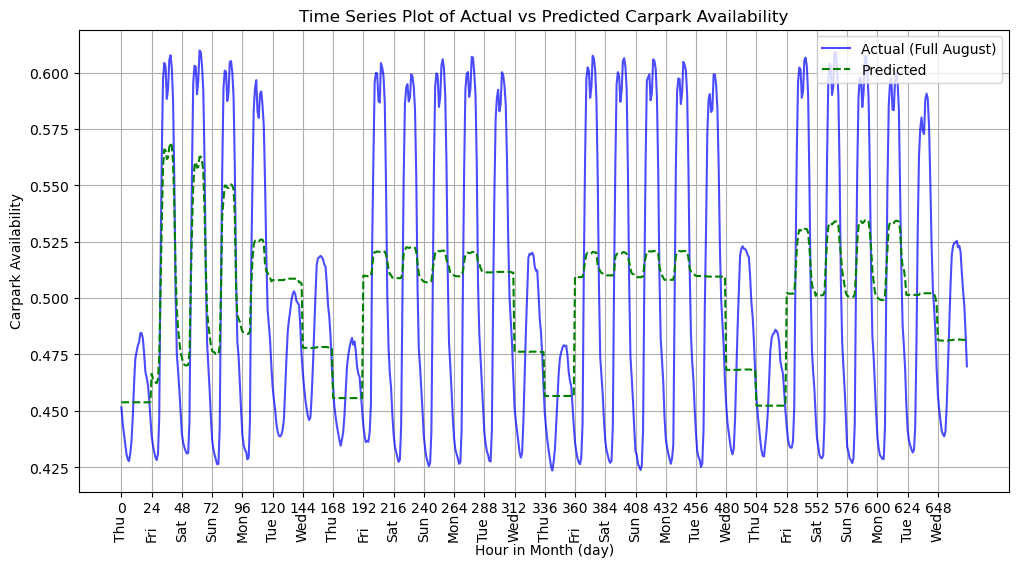

In [45]:
days_of_week = ['Thu', 'Fri', 'Sat', 'Sun', 'Mon', 'Tue', 'Wed']
x_ticks = np.arange(0, august_data['Hour_in_Month'].max() + 1, 24)
x_labels = [f"{int(hour)}" for hour in x_ticks]
day_labels = [days_of_week[(int(hour / 24)) % 7] for hour in x_ticks]

plt.figure(figsize=(12, 6))
plt.plot(august_data['Hour_in_Month'], august_data['Average Availability'], label='Actual (Full August)', color='blue', alpha=0.7)
plt.plot(august_data['Hour_in_Month'], y_pred_tuned, label='Predicted', color='green', linestyle='dashed')
plt.xlabel('Hour in Month (day)', labelpad=20)
plt.ylabel('Carpark Availability')
plt.title('Time Series Plot of Actual vs Predicted Carpark Availability')

plt.xticks(ticks=x_ticks, labels=x_labels)

for i, (tick, day_label) in enumerate(zip(plt.gca().get_xticks(), day_labels)):
    plt.text(tick, -0.1, f"{day_label}", ha='center', rotation=90, transform=plt.gca().get_xaxis_transform())  # Adjust y position (-0.1) for spacing

plt.legend()
plt.grid(True)
plt.show()

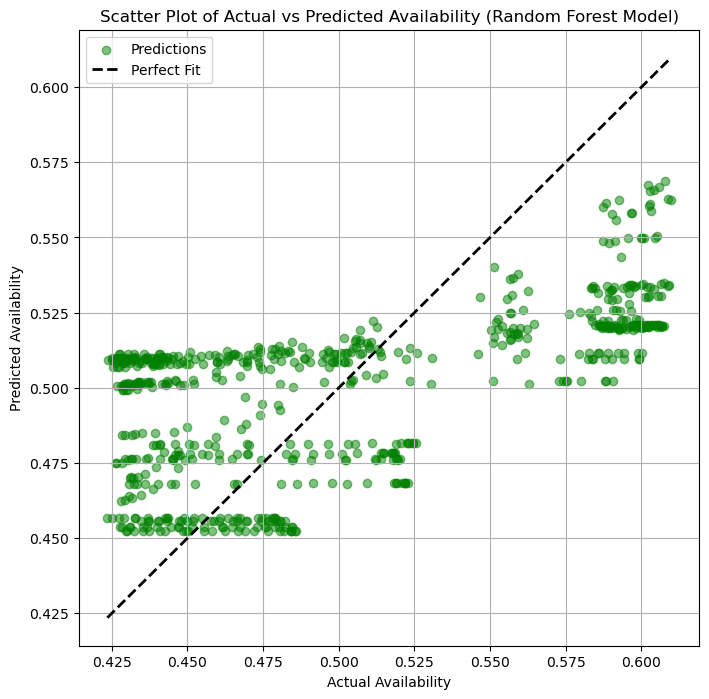

In [46]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_tuned, label='Predictions', alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Fit')
plt.xlabel('Actual Availability')
plt.ylabel('Predicted Availability')
plt.title('Scatter Plot of Actual vs Predicted Availability (Random Forest Model)')
plt.legend()
plt.grid(True)
plt.show()

### Question 2.4
Build a *multi-layer perceptron (MLP)* model to forecast the hourly carpark availability for a given month. Use the month of July 2024 as a training dataset and the month of August 2024 as the test dataset. For this part, do not use additional datasets. The target is the hourly carpark availability and you will have to decide what features you want to use. Generate two plots (i) Time Series plot of the actual and predicted hourly values (ii) Scatter plot of actual vs predicted hourly values (along with a line showing how good the fit is).

In [52]:
df1 = pd.read_csv('july_2024_carpark_availability_interpolated.csv')

df1['Timestamp'] = pd.to_datetime(df1['Timestamp'], dayfirst=True)

df1['day_of_week'] = df1['Timestamp'].dt.strftime('%A')
df1

,Timestamp,Average Availability,day_of_week
0,2024-07-01 00:00:00,0.447390,Monday
1,2024-07-01 01:00:00,0.442392,Monday
2,2024-07-01 02:00:00,0.438597,Monday
3,2024-07-01 03:00:00,0.436202,Monday
4,2024-07-01 04:00:00,0.434242,Monday
...,...,...,...
739,2024-07-31 19:00:00,0.506905,Wednesday
740,2024-07-31 20:00:00,0.484042,Wednesday
741,2024-07-31 21:00:00,0.470131,Wednesday
742,2024-07-31 22:00:00,0.462476,Wednesday


In [53]:
df2 = pd.read_csv('august_2024_carpark_availability_interpolated.csv')
df2['Timestamp'] = pd.to_datetime(df2['Timestamp'], dayfirst=True)

df2['day_of_week'] = df2['Timestamp'].dt.strftime('%A')
df2

,Timestamp,Average Availability,day_of_week
0,2024-08-01 00:00:00,0.438662,Thursday
1,2024-08-01 01:00:00,0.436470,Thursday
2,2024-08-01 02:00:00,0.434963,Thursday
3,2024-08-01 03:00:00,0.430551,Thursday
4,2024-08-01 04:00:00,0.428217,Thursday
...,...,...,...
739,2024-08-31 19:00:00,0.511132,Saturday
740,2024-08-31 20:00:00,0.503066,Saturday
741,2024-08-31 21:00:00,0.496444,Saturday
742,2024-08-31 22:00:00,0.483912,Saturday


In [54]:
encoder = LabelEncoder()
df1['day_of_week_encoded'] = encoder.fit_transform(df1['day_of_week'])
df2['day_of_week_encoded'] = encoder.transform(df2['day_of_week'])

df1['hour'] = pd.to_datetime(df1['Timestamp']).dt.hour
df2['hour'] = pd.to_datetime(df2['Timestamp']).dt.hour

X_train = df1[['hour', 'day_of_week_encoded']]
X_test = df2[['hour', 'day_of_week_encoded']]

y_train = df1['Average Availability']
y_test = df2['Average Availability']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [55]:
param_grid = {
    'hidden_layer_sizes': [(50, 50), (100, 50), (100, 100)], 
    'activation': ['relu', 'tanh'],                           
    'solver': ['adam', 'sgd'],                               
    'learning_rate_init': [0.001, 0.01, 0.1]                  
}

grid_search = GridSearchCV(
    MLPRegressor(max_iter=500, random_state=42),
    param_grid,
    scoring='neg_mean_squared_error',
    cv=10
)

grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Best CV MSE:", -grid_search.best_score_)

Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.01, 'solver': 'adam'}
Best CV MSE: 0.0003020638233587475


In [56]:
y_pred = best_model.predict(X_test_scaled)

mse_mlp = mean_squared_error(y_test, y_pred)
print("Mean Squared Error for Multi-Layered Perceptron:", mse_mlp)

Mean Squared Error for Multi-Layered Perceptron: 0.00045033569412947667


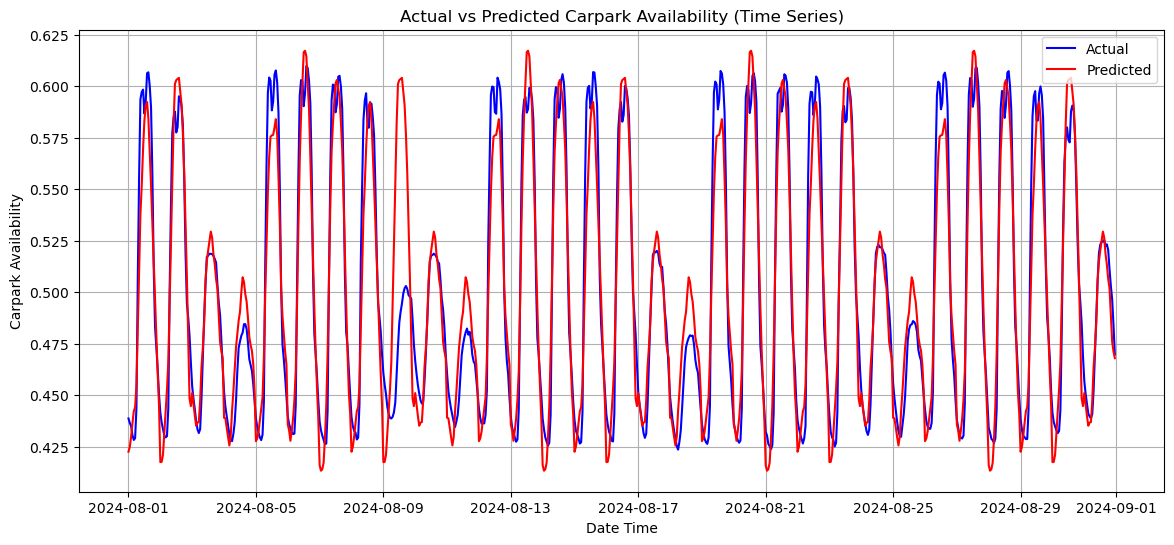

In [57]:
plt.figure(figsize=(14, 6))
plt.plot(df2['Timestamp'], y_test, label='Actual', color='blue')
plt.plot(df2['Timestamp'], y_pred, label='Predicted', color='red')
plt.xlabel('Date Time')
plt.ylabel('Carpark Availability')
plt.title('Actual vs Predicted Carpark Availability (Time Series)')
plt.legend()
plt.grid(True)
plt.show()

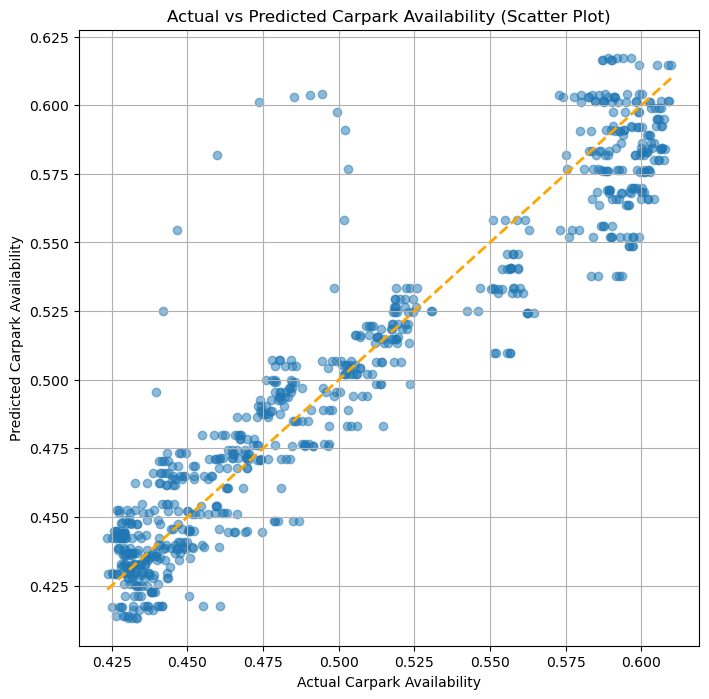

In [59]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='orange', lw=2)  
plt.xlabel('Actual Carpark Availability')
plt.ylabel('Predicted Carpark Availability')
plt.title('Actual vs Predicted Carpark Availability (Scatter Plot)')
plt.grid(True)
plt.show()

### Question 2.5
Make a final recommendation for the best regression model (out of the 3 methods above) by choosing suitable performance metric(s). To ensure a fair comparison, carry out hyperparameter tuning for all 3 methods. Then, make a final recommendation selecting only one model. Include both quantitative and qualitative arguments for your choice.

In [60]:
print("Mean Squared Error for Ridge Regression:", mse_ridge)
print(f"Mean Squared Error for Random Forest Regressor: {mse_rf}")
print("Mean Squared Error for Multi-Layered Perceptron:", mse_mlp)

Mean Squared Error for Ridge Regression: 0.000684455535495323
Mean Squared Error for Random Forest Regressor: 0.0026542615806822356
Mean Squared Error for Multi-Layered Perceptron: 0.00045033569412947667


#### Final Recommendation for the Best Regression Model (Question 2.5)

##### Summary of Models and Their Performance

1. **Ridge Regression**
   - **Mean Squared Error (MSE)**: 0.000684
   - **Advantages**:
     - Ridge regression provides a linear approach to forecasting carpark availability, which often ensures simplicity and interpretability.
     - It is less likely to overfit on small datasets due to its regularization.
   - **Limitations**:
     - While effective with linearly separable data, ridge regression may struggle to capture complex nonlinear patterns.
     - The scatter plot (orange) shows a notable deviation from the "perfect fit" line, particularly at higher values, indicating some difficulty in capturing the variability of availability.

2. **Random Forest Regressor**
   - **Mean Squared Error (MSE)**: 0.002654
   - **Advantages**:
     - Random Forest is a powerful model for capturing complex relationships in the data without extensive feature engineering.
     - It is robust to overfitting due to its ensemble approach, but performance may vary based on hyperparameter tuning.
   - **Limitations**:
     - The higher MSE indicates that the Random Forest model might not be ideal for this dataset.
     - The scatter plot (green) shows distinct clusters of predictions that do not follow a smooth relationship with the actual values, suggesting that the model may have difficulty with finer granularity in the data.

3. **Multi-Layer Perceptron (MLP) Regressor**
   - **Mean Squared Error (MSE)**: 0.000450
   - **Advantages**:
     - The MLP model provides the lowest MSE, indicating that it captured complex relationships within the data more effectively than the other models.
     - It can handle nonlinear data well due to the non-linear activation functions in the hidden layers.
   - **Limitations**:
     - MLPs can be more challenging to interpret than simpler models like ridge regression, as they operate as a "black box."
     - However, the scatter plot (blue) shows that the predictions align closely with the perfect fit line, even for higher values, indicating that the model captures the trends more accurately across the #range of actual values.

#### Recommendation

Based on the Mean Squared Error (MSE) scores and visual inspection of the scatter plots:

- **Multi-Layer Perceptron (MLP)** is recommended as the best model due to its lowest MSE (0.000450), suggesting it achieved the best performance in accurately forecasting hourly carpark availability for #August based on July’s data.
  
#### Quantitative Argument

The MSE for each model shows that the MLP model achieved the best performance, as it minimizes prediction errors on the test dataset. Given that MSE is a critical metric for evaluating regression accuracy, MLP's superior performance is quantitatively significant.

#### Qualitative Argument

The scatter plot for the MLP model (blue) shows a tight alignment along the "perfect fit" line, even at the extremes, indicating that it has captured the underlying trends in carpark availability better than the other models. In contrast, the Ridge Regression plot (orange) deviates more from the perfect fit line, especially at higher values, highlighting its limitations in handling nonlinearity. The Random Forest plot (green) displays clusters, which suggests that the model may have had difficulty capturing finer details in availability patterns. These observations, combined with the lower MSE, strengthe#n the case for choosing the MLP model.

### Final Recommendation
The **Multi-Layer Perceptron (MLP) Regressor** is recommended as the best model due to its balance of accuracy and capability to capture complex patterns, which is ideal for forecasting hourly carpark availability.
